# **Introduction**

In the [paper from UCLA](https://escholarship.org/uc/item/3rs9b3d6) regarding XGBoost and Loan Predictions, they using many different data balancing methods to make sure their data is producing the best results. The accuracy for the base XGBoost algorithm (without a data balancing technique) had the best accuracy. We also observed from the paper that the class weights data balancing technique, although the accuracy was not as good as the base algorithm, had a much better f-measure as well as a much better recall (it is good that the recall is higher here because we want less false negatives i.e. so a bad loan default does not get approved). The paper also used SMOTE and ADASYN balancing methods but they did not compare as well so we will disregard them. We will compare our algorithm which uses Stratified K-fold cross validation as the data balancing technique versus the base and class weights results from the paper.

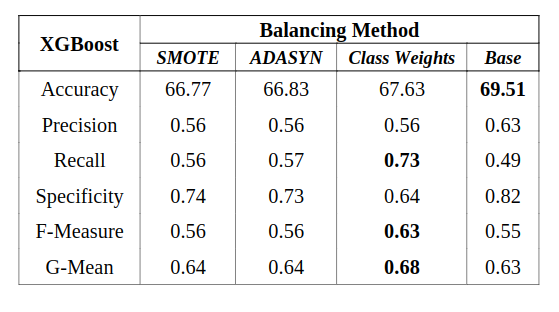

In [1]:
from PIL import Image
Image.open("images/UCLAarticle_performance.png")

As can be seen above, XGBoost with class weights and XGBoost with no data balancing techniques are the superior models so therefore, we will assess our algorithm versus those ones.

In [2]:
import pandas as pd

## Load Data

Below, we are viewing the CSV file as a dataframe. We can observe the various features that will help our XGBoost model predict. The data being loaded in was modified a bit. The original data was the training data, the test data without target feature and the target features for the test data. I combined the test data without target features with its target features in order to have the data more organized. The original data from Kaggle is the in Original_CSV_Data_From_Kaggle folder while the Edited_CSV_Files are the data after the modification mentioned above. 

In [3]:
test_data = pd.read_csv('Edited_CSV_Files/TestData.csv')
train_data = pd.read_csv('Edited_CSV_Files/TrainingData.csv')
train_data.head()

,ID,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [4]:
test_data.head()

,ID,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13,0
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10,0
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14,1
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12,0
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11,0


To determine how many rows and columns each dataframe has, we can call the shape function. The first value in the tuple is the amount of rows while the second value is the amount of columns.

In [5]:
train_data.shape

(252000, 13)

In [6]:
test_data.shape

(28000, 13)

## Combining data into one huge dataset 

Our data is divided into a train set and a test set. To prepare the data for Stratified K-Fold Cross Validation, we must combine the train and test set. This is due to the fact that K-Fold Cross Validation will split the data into multiple groups and choose one as a train set and another as a test set for us. Then, we loop through our XGBoost algorithm on all the different groups to obtain the best accuracy. This will help show that our model is predicting well since it is being tested against "unknown" (It is called unknown data because the algorithm is being trained on different data at each iteration and then predicting on different data each iteration) data and therefore justifing it's accuracy.

In [7]:
train_test_data = [train_data, test_data]

all_data = pd.concat(train_test_data)
all_data = all_data.drop(columns = ['ID']) # we do not need the ID column since pandas already numbers the rows for us
all_data

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
27995,9955481,57,13,single,rented,no,Statistician,Eluru[25],Andhra Pradesh,5,10,0
27996,2917765,47,9,single,rented,no,Technical writer,Ratlam,Madhya Pradesh,9,14,1
27997,8082415,24,5,single,rented,no,Lawyer,Mira-Bhayandar,Maharashtra,4,13,0
27998,9474180,51,13,single,rented,yes,Chartered Accountant,Bhilai,Chhattisgarh,13,14,0


In [8]:
all_data.shape

(280000, 12)

This table has 280,000 rows. Thjis makes sense because the train set had 252,000 rows and the test set had 28,000 rows. Together, that equals 280,000.

## Check for missing values

In [9]:
all_data.isnull().sum() #if all columns sum to zero, it means there are no missing values/nulls

Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

# **Data Preprocessing** 

## Scaling Data 

Scaling data is an important process in the data science process. We must scale our numeric data to not give more weight to values that are greater than smaller values which may not be true (ex: an age column would have an issue in this regard). We will use the Minimum Maximum Scaler formula here which will scale our numeric data between 0 and 1. We should remove the categorical data and scale the numeric data and put the dataframe back together. Here is the min max formula we will be using below:

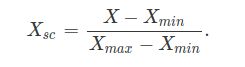

In [10]:
Image.open("images/Min_Max_Scaler_Formula.png")

In [11]:
column_labels = ["Profession","CITY", "STATE","Married/Single", "House_Ownership", "Car_Ownership"]
data_numeric = all_data.drop(columns = column_labels) # to have numeric data separate from categorical in order to perform scaling
data_numeric

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1303834,23,3,3,13,0
1,7574516,40,10,9,13,0
2,3991815,66,4,4,10,0
3,6256451,41,2,2,12,1
4,5768871,47,11,3,14,1
...,...,...,...,...,...,...
27995,9955481,57,13,5,10,0
27996,2917765,47,9,9,14,1
27997,8082415,24,5,4,13,0
27998,9474180,51,13,13,14,0


In [12]:
data_categorical = all_data[column_labels] # to have the categorical data separate from numeric
data_categorical

,Profession,CITY,STATE,Married/Single,House_Ownership,Car_Ownership
0,Mechanical_engineer,Rewa,Madhya_Pradesh,single,rented,no
1,Software_Developer,Parbhani,Maharashtra,single,rented,no
2,Technical_writer,Alappuzha,Kerala,married,rented,no
3,Software_Developer,Bhubaneswar,Odisha,single,rented,yes
4,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,single,rented,no
...,...,...,...,...,...,...
27995,Statistician,Eluru[25],Andhra Pradesh,single,rented,no
27996,Technical writer,Ratlam,Madhya Pradesh,single,rented,no
27997,Lawyer,Mira-Bhayandar,Maharashtra,single,rented,no
27998,Chartered Accountant,Bhilai,Chhattisgarh,single,rented,yes


In [13]:
data_numeric_scaled = (data_numeric-data_numeric.min())/(data_numeric.max()-data_numeric.min())
data_numeric_scaled

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,0.129487,0.034483,0.15,0.214286,0.75,0.0
1,0.757206,0.327586,0.50,0.642857,0.75,0.0
2,0.398564,0.775862,0.20,0.285714,0.00,0.0
3,0.625263,0.344828,0.10,0.142857,0.50,1.0
4,0.576454,0.448276,0.55,0.214286,1.00,1.0
...,...,...,...,...,...,...
27995,0.995550,0.620690,0.65,0.357143,0.00,0.0
27996,0.291047,0.448276,0.45,0.642857,1.00,1.0
27997,0.808049,0.051724,0.25,0.285714,0.75,0.0
27998,0.947370,0.517241,0.65,0.928571,1.00,0.0


In [14]:
all_data_scaled = pd.concat([data_categorical, data_numeric_scaled], axis=1)
all_data_scaled

,Profession,CITY,STATE,Married/Single,House_Ownership,Car_Ownership,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,Mechanical_engineer,Rewa,Madhya_Pradesh,single,rented,no,0.129487,0.034483,0.15,0.214286,0.75,0.0
1,Software_Developer,Parbhani,Maharashtra,single,rented,no,0.757206,0.327586,0.50,0.642857,0.75,0.0
2,Technical_writer,Alappuzha,Kerala,married,rented,no,0.398564,0.775862,0.20,0.285714,0.00,0.0
3,Software_Developer,Bhubaneswar,Odisha,single,rented,yes,0.625263,0.344828,0.10,0.142857,0.50,1.0
4,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,single,rented,no,0.576454,0.448276,0.55,0.214286,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
27995,Statistician,Eluru[25],Andhra Pradesh,single,rented,no,0.995550,0.620690,0.65,0.357143,0.00,0.0
27996,Technical writer,Ratlam,Madhya Pradesh,single,rented,no,0.291047,0.448276,0.45,0.642857,1.00,1.0
27997,Lawyer,Mira-Bhayandar,Maharashtra,single,rented,no,0.808049,0.051724,0.25,0.285714,0.75,0.0
27998,Chartered Accountant,Bhilai,Chhattisgarh,single,rented,yes,0.947370,0.517241,0.65,0.928571,1.00,0.0


Now, the categorical data and the scaled numeric data are back in the same dataframe.

## One Hot Encoding

Some of the columns such as profession, city and home_ownership in the dataframe are not numeric or binary data. In order to build a sufficient ML model, we must change our categorical data into numeric or binary data. There are two popular methods of encoding: label encoding and one hot encoding. Label encoding is ideal when using ordinal data but in our case, all the data we are changing is categorical data so we would want to use one hot encoding which is best for this situation. One hot encoding will convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns which will classify all the categorical data as binary data. Below we will implement one hot encoding using the pandas library get_dummies() function. 

In [15]:
from sklearn.preprocessing import LabelEncoder

column_labels = ["Profession","CITY", "STATE","Married/Single", "House_Ownership", "Car_Ownership"]
data_categorical = all_data_scaled.copy()

data_one_hot_encoded = pd.get_dummies(data_categorical, columns = column_labels)


Let us view the new columns after the change from categorical data to binary data. 

In [16]:
data_one_hot_encoded.columns.tolist()

['Income',
 'Age',
 'Experience',
 'CURRENT_JOB_YRS',
 'CURRENT_HOUSE_YRS',
 'Risk_Flag',
 'Profession_Air traffic controller',
 'Profession_Air_traffic_controller',
 'Profession_Analyst',
 'Profession_Architect',
 'Profession_Army officer',
 'Profession_Army_officer',
 'Profession_Artist',
 'Profession_Aviator',
 'Profession_Biomedical Engineer',
 'Profession_Biomedical_Engineer',
 'Profession_Chartered Accountant',
 'Profession_Chartered_Accountant',
 'Profession_Chef',
 'Profession_Chemical engineer',
 'Profession_Chemical_engineer',
 'Profession_Civil engineer',
 'Profession_Civil servant',
 'Profession_Civil_engineer',
 'Profession_Civil_servant',
 'Profession_Comedian',
 'Profession_Computer hardware engineer',
 'Profession_Computer operator',
 'Profession_Computer_hardware_engineer',
 'Profession_Computer_operator',
 'Profession_Consultant',
 'Profession_Dentist',
 'Profession_Design Engineer',
 'Profession_Design_Engineer',
 'Profession_Designer',
 'Profession_Drafter',
 'Profe

As can be seen above, there are a lot more columns. This is necessary because we cannot build learning models from categorical data. There are 458 columns now as opposed to 11 before to account for the categorical data.

# Building Our Model

Before building the model, lets split our target feature from our other features

In [19]:
X = data_one_hot_encoded.drop(columns = ['Risk_Flag'])
X

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Profession_Air traffic controller,Profession_Air_traffic_controller,Profession_Analyst,Profession_Architect,Profession_Army officer,...,STATE_Uttarakhand,STATE_West Bengal,STATE_West_Bengal,Married/Single_married,Married/Single_single,House_Ownership_norent_noown,House_Ownership_owned,House_Ownership_rented,Car_Ownership_no,Car_Ownership_yes
0,0.129487,0.034483,0.15,0.214286,0.75,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
1,0.757206,0.327586,0.50,0.642857,0.75,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
2,0.398564,0.775862,0.20,0.285714,0.00,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
3,0.625263,0.344828,0.10,0.142857,0.50,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
4,0.576454,0.448276,0.55,0.214286,1.00,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.995550,0.620690,0.65,0.357143,0.00,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
27996,0.291047,0.448276,0.45,0.642857,1.00,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
27997,0.808049,0.051724,0.25,0.285714,0.75,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
27998,0.947370,0.517241,0.65,0.928571,1.00,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1


In [21]:
Y = data_one_hot_encoded['Risk_Flag']
Y

0        0.0
1        0.0
2        0.0
3        1.0
4        1.0
        ... 
27995    0.0
27996    1.0
27997    0.0
27998    0.0
27999    0.0
Name: Risk_Flag, Length: 280000, dtype: float64

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
xgb_model = XGBClassifier() #
#xgb_model.fit(train_data, train_target)

In [ ]:
train_data